## **Imports**

In [ ]:
# Utils
import time
import random
import sys
from tqdm import tqdm

# Data Structures
import heapq

# Data Manipulation and computations
import numpy as np
import pandas as pd
import scipy.spatial.distance as dist
import operator

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import deque
from statsmodels.stats.weightstats import ztest, ttest_ind

## **A-Star Search**

In [ ]:
#@title Util Functions for A* Search

class Node:
  
  def __init__(self, parent=None, position=None, recency_factor=None):
    """ Represents a Node in the A* search tree. """

    self.parent = parent
    self.position = position
    self.recency_factor = recency_factor

    self.g = 0
    self.h = 0
    self.f = 0
  
  def __eq__(self,other):
    """ For Node comparison. """
    if type(self) != type(other):
      return False

    return self.position == other.position
  
  def __lt__(self, other):
    """ For heap comparison. """
    if self.f < other.f:
      return True
    elif self.f == other.f:
      if self.recency_factor > other.recency_factor:
        return True
    
    return False

  def __gt__(self, other):
    if self.f > other.f:
      return True
    elif self.f == other.f:
      if self.recency_factor < other.recency_factor:
        return True
    
    return False

def grid_path(current_node):
  """ Recursively finds the path from the leaf to the root node in the A* search tree. """
  path = []

  current = current_node
  while current != None:
    path.append(current.position)
    current = current.parent

  return path[::-1]

def heuristic(name, start, end):
  """ Returns the heuristic (distance) between the start and end points. """
  if name == "euclidean":
    return dist.euclidean(start, end)
  elif name == "manhattan":
    return dist.cityblock(start, end)
  elif name == "chebyshev":
    return dist.chebyshev(start, end)
  
  raise NotImplementedError("Unknown heuristic:", name)

def is_unvisited_and_unblocked(coords, state):
  """Removes visited and blocked cells"""

  x, y = coords
  knowledge, visited, _ = state
  if knowledge[x][y] != 0 or visited[x][y] != 0:
    return False

  return True

def is_open_cell(cell, knowledge):
  nbhd = neighbourhood(cell, knowledge.shape[0], knowledge.shape[1])

  unblocked = [nbr for nbr in nbhd if knowledge[nbr[0]][nbr[1]] != 1]

  if len(unblocked) >= 3:
    return True

  return False

def neighbourhood(coords, num_rows, num_cols, nbhd_type="compass", parent_coords=None):
  if nbhd_type == "compass":

    # Get possible cells
    x, y = coords
    possible_cells = [(x+1, y), (x, y+1), (x-1, y), (x, y-1)]

    # Remove cells outside boundaries
    possible_cells = [cell for cell in possible_cells if cell[0] >= 0 and cell[1] >= 0 and cell[0] <= num_rows-1 and cell[1] <= num_cols-1]

    return possible_cells
  
  elif nbhd_type == "directional":

    if parent_coords is None:
      raise ValueError("Parent coords cannot be none if nbhd_type == 'directional'.")

    # Find the possible neighbouring node in the field of view
    cell = tuple(np.array(coords) + (np.array(coords) - np.array(parent_coords)))

    # Check if the node is valid
    possible_cells = [cell] if cell[0] >= 0 and cell[1] >= 0 and cell[0] <= num_rows-1 and cell[1] <= num_cols-1 else []

    return possible_cells
  
  raise ValueError("nbhd type can only be from ['compass', 'directional'], not", nbhd_type)

def get_valid_children(coords, parent, num_rows, num_cols, state):
  """Assume grid: [(0, 0) -> (num_rows-1, num_cols-1)]"""

  # Get all possible children
  nbhd = neighbourhood(coords, num_rows, num_cols)

  if parent is not None:
    nbhd = [x for x in nbhd if x != parent.position]

  # Remove known blocked and visited cells
  valid_children = [cell for cell in nbhd if is_unvisited_and_unblocked(cell, state)]

  return valid_children

In [ ]:
#@title Generate Gridworld

def generate_gridworld(shape, block_prob):
  num_rows, num_cols = shape

  val = np.empty((), dtype=object)
  val[()] = (0, 0)

  grid_world = np.full((num_rows, num_cols), val, dtype=object)

  p = [(num_rows * num_cols)/3,(num_rows * num_cols)/3,(num_rows * num_cols)/3]
  p = np.array(p)
  p = p/p.sum()
  
  for i in range(num_rows):
    for j in range(num_cols):
      grid_world[i][j] = (np.random.choice([1, 0], p=[block_prob, 1-block_prob]),np.random.choice([0.2,0.5,0.8], p=p))

  # Exclude start and end cells
  goal_node = (np.random.randint(0,num_rows-1),np.random.randint(0,num_cols-1))
  grid_world[0][0] = (0,grid_world[0][0][1])
  grid_world[goal_node[0]][goal_node[0]] = (0,grid_world[0][0][1])
  
  return np.array(grid_world), goal_node

In [ ]:
generate_gridworld((30, 30), 0.3)

(array([[(0, 0.2), (0, 0.8), (0, 0.8), (1, 0.2), (0, 0.8), (0, 0.5),
         (0, 0.8), (0, 0.2), (0, 0.2), (0, 0.2), (0, 0.8), (1, 0.8),
         (1, 0.2), (0, 0.5), (0, 0.5), (0, 0.5), (1, 0.8), (0, 0.5),
         (0, 0.5), (0, 0.2), (0, 0.2), (0, 0.2), (1, 0.8), (0, 0.2),
         (0, 0.2), (0, 0.2), (0, 0.2), (0, 0.8), (0, 0.2), (0, 0.8)],
        [(0, 0.5), (1, 0.2), (0, 0.2), (0, 0.8), (0, 0.2), (0, 0.8),
         (0, 0.2), (0, 0.5), (0, 0.8), (0, 0.5), (1, 0.2), (0, 0.8),
         (0, 0.2), (0, 0.5), (0, 0.8), (1, 0.8), (0, 0.2), (0, 0.5),
         (0, 0.2), (0, 0.8), (1, 0.5), (0, 0.8), (0, 0.5), (0, 0.8),
         (0, 0.8), (0, 0.8), (0, 0.8), (0, 0.8), (0, 0.5), (0, 0.8)],
        [(0, 0.5), (0, 0.2), (0, 0.5), (1, 0.2), (0, 0.5), (0, 0.2),
         (0, 0.8), (0, 0.2), (0, 0.8), (0, 0.2), (0, 0.2), (0, 0.8),
         (0, 0.5), (0, 0.2), (0, 0.2), (1, 0.2), (0, 0.8), (0, 0.2),
         (1, 0.2), (1, 0.8), (0, 0.2), (0, 0.8), (0, 0.8), (0, 0.5),
         (0, 0.8), (1, 0.5), (0,

In [ ]:
#@title Older Version of A* Search

def a_star_search(start, goal, grid, heuristic_type, visited, knowledge, max_steps=None, nbhd="directional", epsilon=1.):
  """ nbhd: 'compass' or 'directional' """

  if knowledge[goal[0]][goal[1]] == 1:
    return [], "BLOCKED_GOAL", 0

  start_node = Node(None, start)
  goal_node = Node(None, goal)

  # Implementing priority queue using heap
  fringe = []
  in_fringe = np.zeros(grid.shape)

  heapq.heapify(fringe)

  recency_counter = 0
  num_cells_popped = 0

  start_node.recency_factor = recency_counter
  heapq.heappush(fringe, start_node)
  in_fringe[start[0]][start[1]] = 1

  recency_counter += 1
  
  # Stopping condition
  if max_steps is None:
    max_steps = sys.maxsize

  steps = 0
  exit_status = "FAILED_NOPATH"

  # Start
  while fringe:
    
    steps += 1

    # Pop the current node from the fringe
    current_node = heapq.heappop(fringe)
    num_cells_popped += 1
    curr_x, curr_y = current_node.position

    # Visit the current node and note that it is out of the fringe
    visited[curr_x][curr_y] = 1
    in_fringe[curr_x][curr_y] = 0

    # Check and return path if we have reached the goal node
    if current_node == goal_node:
      exit_status = "SUCCESS"
      return grid_path(current_node), exit_status, num_cells_popped

    # Stopping condition
    if steps > max_steps:
      exit_status = "FAILED_STEPS"
      return grid_path(current_node), exit_status, num_cells_popped

    # Create children
    children = get_valid_children(current_node.position, current_node.parent, grid.shape[0], grid.shape[1], (knowledge, visited, in_fringe))
    children = [Node(current_node, x) for x in children]

    for i in range(len(children)):
      children[i].g = current_node.g + 1
      children[i].h = heuristic(heuristic_type, children[i].position, goal)
      children[i].f = children[i].g + epsilon*children[i].h
      children[i].recency_factor = recency_counter

      heapq.heappush(fringe, children[i])
      in_fringe[children[i].position[0]][children[i].position[1]] = 1

      recency_counter += 1

  return [], exit_status, num_cells_popped

In [ ]:
#@title Visualize Grid, Test A* Custom

def visualize_grid(sol, grid):
  vis_grid = grid.copy().astype(str)

  for cell in sol:
    vis_grid[cell[0]][cell[1]] = "*"

  return vis_grid

pretty_print = lambda A: print('\n'.join([''.join(['{:4}'.format(item) for item in row]) for row in A]))

def test_a_star_search_custom():
  grid = [[0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
          [0, 1, 0, 1, 1, 0, 1, 0, 0, 0],
          [0, 1, 1, 1, 0, 0, 0, 0, 1, 0],
          [0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
          [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
          [0, 1, 0, 1, 0, 0, 1, 0, 0, 1],
          [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
          [0, 1, 0, 1, 1, 0, 1, 0, 0, 1],
          [0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
          [1, 1, 0, 1, 0, 0, 0, 0, 1, 0]]

  grid = np.array(grid)

  visited = np.zeros(grid.shape)
  blocked = grid.copy()

  sol = a_star_search((0, 0), (grid.shape[0]-1, grid.shape[1]-1), grid, "euclidean", visited, blocked)

  pretty_print(grid)
  print("\n")
  pretty_print(visualize_grid(sol, grid))

## **Repeated A-Star**

In [ ]:
def update_on_blocked(probability_grid, cell, grid):
  num_rows, num_cols = probability_grid.shape

  orig_prob = probability_grid[cell[0],cell[1]]

  probability_grid[cell[0], cell[1]] = 0

  grid_sum = np.sum(probability_grid)
  FNR = grid[cell[0], cell[1]][1]

  probability_grid = probability_grid / (1-orig_prob)  
  return probability_grid

def update_on_unblocked(probability_grid, cell, grid):
  num_rows, num_cols = probability_grid.shape
  FNR = grid[cell[0], cell[1]][1]
  orig_prob = probability_grid[cell[0],cell[1]] 
  
  probability_grid[cell[0],cell[1]] = FNR * orig_prob
  probability_grid = probability_grid / (1-(orig_prob * (1-FNR)))  
  return probability_grid

In [ ]:
def examine(cell, grid, original_goal):
  """ Function called when agent moves to unblocked cell to check for target """
  
  if cell == original_goal:
    rand_val = np.random.rand()
    return 1 if rand_val > grid[cell[0]][cell[1]][1] else 0
  else:
    return 0

In [ ]:
def bfs_distance(start, knowledge, scale=True):
  distance_to_cell = np.full(knowledge.shape, np.inf)
  visited = np.zeros(knowledge.shape)

  q = deque()

  q.append(start)
  distance_to_cell[start[0]][start[1]] = 0
  visited[start[0]][start[1]] = 1

  max_dist = -1

  while q:
    v = q.popleft()

    nbhd = neighbourhood(v, knowledge.shape[0], knowledge.shape[1])

    for nbr in nbhd:
      if visited[nbr[0]][nbr[1]] != 1 and knowledge[nbr[0]][nbr[1]] != 1:
        q.append(nbr)
        visited[nbr[0]][nbr[1]] = 1
        distance_to_cell[nbr[0]][nbr[1]] = distance_to_cell[v[0]][v[1]] + 1

        if distance_to_cell[nbr[0]][nbr[1]] > max_dist:
          max_dist = distance_to_cell[nbr[0]][nbr[1]]

  if scale:
    distance_to_cell[start[0]][start[1]] += np.inf
    distance_to_cell = distance_to_cell/max_dist + 0.5

  return distance_to_cell

In [ ]:
#@title Check Target

def check_target(probability_grid):
  """ Function to check the cell with max probability of containing target """

  return np.unravel_index(np.argmax(probability_grid), shape=probability_grid.shape)

In [ ]:
#@title Distance Broadcasted

def distance_broadcasted(cell, probability_grid, scale=True, zero_self_imp=True, distance_func="manhattan"):
  """ 
  Calculates the manhattan distance for each cell from a particular cell.

  Parameters
  ----------
    scale: Scales values to [0, 1] such that min manhattan distance is given
      the highest importance and vice-versa.
    zero_self_imp: Sets the potential of `cell` to zero.
  """

  man_grid = np.zeros(probability_grid.shape)
  max_dist = -1

  if distance_func != "manhattan":
    raise NotImplementedError("Distance function can only be one of ['manhattan'].")

  for i in range(probability_grid.shape[0]):
    for j in range(probability_grid.shape[1]):
      man_grid[i][j] = dist.cityblock(cell, (i, j))

      if man_grid[i][j] > max_dist:
        max_dist = man_grid[i][j]

  if not scale:
    return man_grid

  importance = 1 - man_grid/max_dist

  if zero_self_imp:
    importance[cell[0]][cell[1]] = 0

  return importance

In [ ]:
def break_ties_by_grid(value_grid, cells_to_choose_from, default_choice="random"):
  cells_tuple_form = list(map(tuple, cells_to_choose_from.T))
  values_for_best_cells = value_grid[cells_to_choose_from[0], cells_to_choose_from[1]]
  best_indices = np.argwhere(values_for_best_cells == np.max(values_for_best_cells)).reshape(-1)
  best_cells = [cells_tuple_form[i] for i in best_indices if 0 <= i < len(cells_tuple_form)]

  if len(best_cells) > 1:
    if default_choice == "random":
      return random.choice(best_cells)
    elif default_choice == "first":
      return best_cells[0]
    else:
      raise ValueError("Default choice can only be 'random' or 'first'.")

  return best_cells[0]

def find_goal_8(cell, probability_grid, knowledge, terrain_knowledge, alpha=0.5, break_ties="distance", default_choice="random"):
  """ Finds goal for Agent 8 """

  if break_ties not in ("distance", "probability"):
    raise ValueError("break_ties can only be 'distance' or 'probability'.")

  finding_grid = np.multiply(probability_grid, 1 - terrain_knowledge) 

  distance_grid = 1/bfs_distance(cell, knowledge)
  utility = np.multiply(finding_grid, distance_grid)
  # utility = alpha*distance_grid + (1 - alpha)*finding_grid

  cells_to_choose_from = np.argwhere(utility == np.amax(utility)).T

  if len(cells_to_choose_from) > 1:
    if break_ties == "distance":
      return break_ties_by_grid(distance_grid, cells_to_choose_from, default_choice=default_choice)
    elif break_ties == "probability":
      return break_ties_by_grid(probability_grid, cells_to_choose_from, default_choice=default_choice)
  elif len(cells_to_choose_from) <= 0:
    raise ValueError("Zero cells to choose from!")
  
  return cells_to_choose_from.T[0]

In [ ]:
#@title New A* Search

def a_star_search_new(start, goal, grid, heuristic_type, 
                    visited, knowledge, max_steps=None, 
                    epsilon=1.):
  """ 
  Executes A* search on a grid.

  Parameters
  ----------
  start: (int, int)
    Coordinates of the start cell.
  goal: (int, int)
    Coordinates of the goal cell.
  grid: 2D np.array
    Represents the original grid on which A* needs to be executed
  heuristic_type: str
    Type of heuristic to use. Can be `'euclidean'`, `'manhattan'`, or `'chebyshev'`
  visited: 2D np.array
    Represents which nodes the agent has already expanded. visited[x][y] = 1 if
    the agent has already expanded Node at (x, y) and 0 otherwise.
  knowledge: 2D np.array
    Represents the knowledge of the agent. knowledge[x][y] = 1 if
    the agent knows there exists a block at position (x, y) and is 0 otherwise.
  max_steps: int or None
    Max. number of times we pop a Node from the Fringe
  epsilon: float
    Weight given to the heuristic function while calculating the priority f. Used as:
    f(n) = g(n) + epsilon*h(n)

  Returns
  -------
  planned_path: List[(int, int)]
    List of cells to traverse from the start node to end node
  exit_status: str
    `"SUCCESS"` - If A* was successfully completed
    `"FAILED_NOPATH"` - If no path can be found from the start to the goal cells
    `"FAILED_STEPS"` - Max. number of steps was reached and path not found
  num_cells_popped: int
    Total number of nodes popped from the fringe throughout the search process.
  
  TODO
  ----
  - num_cells_popped == steps? Remove num_cells_popped and use steps instead
  - Remove the `grid` parameter since this is not required
  - Implement a separate `Fringe` class
  """

  if knowledge[goal[0]][goal[1]] == 1:
    return [], "BLOCKED_GOAL", 0

  start_node = Node(position=start)
  goal_node = Node(position=goal)

  # Implementing priority queue using heap
  fringe = []
  in_fringe = np.full(grid.shape, np.inf)
  heapq.heapify(fringe)

  # Initialize tracking parameters
  recency_counter = 0
  num_cells_popped = 0

  # Add start node to the fringe
  start_node.recency_factor = recency_counter
  heapq.heappush(fringe, start_node)
  in_fringe[start[0]][start[1]] = start_node.f
  recency_counter += 1
  
  # Stopping condition
  if max_steps is None:
    max_steps = sys.maxsize

  steps = 0
  exit_status = "FAILED_NOPATH"

  # Start
  while fringe:
    
    steps += 1

    # Pop the current node from the fringe
    current_node = heapq.heappop(fringe)
    num_cells_popped += 1
    curr_x, curr_y = current_node.position

    # Visit the current node and note that it is out of the fringe
    visited[curr_x][curr_y] = 1
    in_fringe[curr_x][curr_y] = 0

    # Check and return path if we have reached the goal node
    if current_node == goal_node:
      exit_status = "SUCCESS"
      return grid_path(current_node), exit_status, num_cells_popped

    # Stopping condition
    if steps > max_steps:
      exit_status = "FAILED_STEPS"
      return grid_path(current_node), exit_status, num_cells_popped

    # Create children
    children = get_valid_children(current_node.position, current_node.parent, grid.shape[0], grid.shape[1], (knowledge, visited, in_fringe))
    children = [Node(current_node, x) for x in children]

    # Set parameters for each child
    for i in range(len(children)):
      children[i].g = current_node.g + 1
      children[i].h = heuristic(heuristic_type, children[i].position, goal)
      children[i].f = children[i].g + epsilon*children[i].h
      children[i].recency_factor = recency_counter

      if children[i].f < in_fringe[children[i].position[0]][children[i].position[1]]:
        heapq.heappush(fringe, children[i])
        in_fringe[children[i].position[0]][children[i].position[1]] = children[i].f

      recency_counter += 1

  return [], exit_status, num_cells_popped

In [ ]:
#@title Move and Record

def move_and_record(start, goal, grid, planned_path, knowledge, probability_grid, original_goal, terrain_knowledge, nbhd_type="directional"):
  """
  Moves the robot along the path and records the environment as it travels.
  If a block is encountered, returns the last unblocked location.

  Parameters
  ----------
  start: (int, int)
    The start coordinates in the grid. Between (0, 0) and 
    (grid.shape[0]-1, grid.shape[1]-1).
  goal: (int, int) 
    The goal coordinates in the grid. Limits are similar to start.
  planned_path: List[(int, int)]
    List of coordinates (including start and end) to visit.
  knowledge: 2D np.array
    2D array representing all blocked cells the robot has seen so far.
    All other cells are marked 0.
  
  Returns
  -------
  final_node: (int, int)
    The last unblocked node visited or the goal node.
  knowledge: 2D np.array
    Updated knowledge array.
  steps: int
    Number of steps taken along the path.
  """

  if not planned_path:  # Planned path is empty
    raise ValueError("Planned path cannot be empty.")

  if planned_path[0] != start:  # Planned path and start don't coincide
    raise ValueError("Planned path doesn't start with 'start'! planned_path[0] =", 
                     planned_path[0], "start =", start)

  steps = 0
  num_examine = 0 
  last_open_cell = None

  # Start moving
  for i in range(len(planned_path)):
    cell = planned_path[i]

    # If cell is blocked, return the last known location
    if grid[cell[0]][cell[1]][0] == 1:
      knowledge[cell[0]][cell[1]] = 1
      terrain_knowledge[cell[0]][cell[1]] = 1
      probability_grid = update_on_blocked(probability_grid, cell, grid)
      return planned_path[i-1], knowledge, steps, last_open_cell, probability_grid, num_examine, terrain_knowledge

    #if cell is unblocked, we call examine to check for target:
    target_found = 0
    terrain_knowledge[cell[0]][cell[1]] = grid[cell[0]][cell[1]][1] 
    if cell == goal:
      target_found = examine(cell, grid, original_goal)
      num_examine += 1
    
      if target_found == 1:
        return goal, knowledge, steps, last_open_cell, probability_grid, num_examine, terrain_knowledge
        #termination condition
      else:
        probability_grid = update_on_unblocked(probability_grid,cell,grid)        
        return planned_path[i], knowledge, steps, last_open_cell, probability_grid, num_examine, terrain_knowledge
    
    # Find all neighbouring cells and update knowledge
    parent_coords = planned_path[i-1] if i-1 > 0 else tuple(np.array(cell) - (np.array(planned_path[i+1]) - np.array(cell)))
    nbhd = neighbourhood(cell, grid.shape[0], grid.shape[1], nbhd_type=nbhd_type, parent_coords=planned_path[i-1])

    for nbr in nbhd:
      knowledge[nbr[0]][nbr[1]] = grid[nbr[0]][nbr[1]][0]

    if is_open_cell(cell, knowledge):
      last_open_cell = cell

    steps += 1

  return planned_path[i], knowledge, steps, last_open_cell, probability_grid, num_examine, terrain_knowledge

In [ ]:
#@title Convert Tuple 2D Array to np arrays

def tuple_2d_array_2_np_array(x):
  blocks = np.zeros(x.shape)
  probs = np.zeros(x.shape)

  for i in range(x.shape[0]):
    for j in range(x.shape[1]):
      blocks[i][j] = x[i][j][0]
      probs[i][j] = x[i][j][1]

  return blocks.astype(int), probs

In [ ]:
random.randint(1, 10)

7

In [ ]:
class RepeatedAStar:

  def __init__(self, grid, move_nbhd_type="directional", epsilon=1., 
               alpha=0.5, escape_tunnels=False):
    """ Implements the Repeated A* algorithm on a grid-world. 
    
    Parameters
    ----------
    grid: 2D np.array
      The grid world on which we need to implement the algorithm
    move_nbhd_type: str
      Can be 'compass' (see in all 4 directions in the execution phase) 
      or 'directional' (see in only the direction of the movement 
      in the execution phase)
    epsilon: float
      Weight with which the heuristic function is multiplied, as:
      f(n) = g(n) + epsilon*h(n)
    escape_tunnels: bool
      Set to true to restart A* from the start of a tunnel by backtracking
      instead of dead-ends
    """

    # Logging
    self.knowledge_snaps = []
    self.visited_snaps = []
    self.start_end_snaps = []
    self.sol_snaps = []
    self.moves = 0
    self.examinations = 0
    self.successfully_completed = False
    self.final_exit_status = None
    self.grid = grid
    self.total_cells_processed_by_run = []
    self.backtracks = []
    self.terrain = 0
    self.times_per_iteration = []

    # Algorithm parameters
    self.alpha = alpha
    self.epsilon = epsilon
    self.move_nbhd_type = move_nbhd_type
    self.escape_tunnels = escape_tunnels

  def _update_state(self, knowledge, visited, path_end_points, soln, 
                    moves, successfully_completed, final_exit_status, 
                    num_cells_popped, examinations, terrain, time_for_iteration):
    """ Updates the state (logging variables) after each run of the planning + execution phases. 
    
    Parameters
    ----------
    knowledge: 2D np.array
      Represents the agent's copy of the grid-world discovered so far.
    visited: 2D np.array
    """
    
    self.knowledge_snaps.append(knowledge)
    self.visited_snaps.append(visited)
    self.start_end_snaps.append(path_end_points)
    self.sol_snaps.append(soln)
    self.moves = moves
    self.examinations = examinations
    self.successfully_completed = successfully_completed
    self.final_exit_status = final_exit_status
    self.total_cells_processed_by_run.append(num_cells_popped)
    self.terrain = terrain
    self.times_per_iteration.append(time_for_iteration)

  def logs(self):
    return {
        "grid": self.grid,
        "knowledge": self.knowledge_snaps,
        "visited": self.visited_snaps,
        "start_end": self.start_end_snaps,
        "solns": self.sol_snaps,
        "moves": self.moves,
        "examinations": self.examinations,
        "successfully_completed": self.successfully_completed,
        "final_exit_status": self.final_exit_status,
        "terrain": self.terrain
    }

  def path_followed(self):
    """ Returns the actual path followed (planning + execution) """

    # If the paths followed and solutions don't match
    assert len(self.sol_snaps) == len(self.start_end_snaps), \
      "More steps for A* than elements in start_end."
    
    full_path = []
    for i in range(len(self.start_end_snaps)):

      # Get index of end node in path
      _, end_node = self.start_end_snaps[i]
      end_index = self.sol_snaps[i].index(end_node)

      # Clip the array according to end index and append to parent array
      clipped_array = self.sol_snaps[i][:end_index]
      full_path += clipped_array

    return full_path

  def total_cells_processed(self):
    """ Returns total cells processed by the run """
    return sum(self.total_cells_processed_by_run)

  def total_backtracked_cells(self):
    """ Returns total number of backtracked cells """
    flat_list = [item for sublist in self.backtracks for item in sublist]
    return len(flat_list)

  def search(self, start, original_goal, grid, heuristic_type,
             max_steps_astar=None, max_steps_repeated=None, random_sample=False):

    # Exit condition
    if max_steps_repeated is None:
      max_steps_repeated = sys.maxsize

    # Save original goal
    self.original_goal = original_goal

    # Initialize visited matrix, knowledge matrix and probability grid
    knowledge = np.zeros(grid.shape)
    terrain_knowledge = np.full(knowledge.shape, 0.5)
    probability_grid = np.full(grid.shape, 1/(grid.shape[0] * grid.shape[1]))

    planned_path = []
    last_open_cell = None
    replan_goal = False
    self.iteration = 0

    while not self.successfully_completed:
      iter_start_time = time.time()

      # If number of steps have been exceeded for Repeated A*
      if self.moves > max_steps_repeated:
        self._update_state(None, None, (None, None), None, None, False,
                           "FAILED_STEPS_REP", 0, None, time.time() - iter_start_time)
        
        self.iteration += 1
        return

      if random_sample:
        if np.random.randint(1, 10) == 7:
          return

      # Initialize empty visited array for this run of A* search
      visited = np.zeros(grid.shape)

      # Find the next goal
      goal = find_goal_8(start, probability_grid, knowledge, terrain_knowledge, alpha=self.alpha)

      # Run A* search algorithm once
      planned_path, exit_status, num_cells_popped = \
        a_star_search_new(start, goal, grid, heuristic_type, 
                          visited, knowledge, max_steps=max_steps_astar, 
                          epsilon=self.epsilon)

      # If Goal is known to be blocked
      if exit_status == "BLOCKED_GOAL":
        probability_grid = update_on_blocked(probability_grid, goal, knowledge, grid)
        continue

      # If no path can be found      
      if exit_status == "FAILED_NOPATH":
        knowledge[goal[0]][goal[1]] = 1
        probability_grid = update_on_blocked(probability_grid, goal, knowledge, grid)

        self._update_state(knowledge, visited, (start, None), planned_path, 
                           self.moves, False, exit_status , num_cells_popped, 
                           self.examinations, grid[original_goal[0]][original_goal[1]][1], 
                           time.time() - iter_start_time)
        
        self.iteration += 1
        continue

      # If num of steps were exceeded for one run of A*
      elif exit_status == "FAILED_STEPS":
        self._update_state(knowledge, visited, (start, None), planned_path, 
                           self.moves, False, exit_status, num_cells_popped, 
                           self.examinations, grid[original_goal[0]][original_goal[1]][1], 
                           time.time() - iter_start_time)
        
        self.iteration += 1
        return

      # Move robot along the grid on the planned path and record environment
      final_node, knowledge, moves, last_open_cell, probability_grid, num_examine,terrain_knowledge = move_and_record(start, goal, grid, 
                                                                planned_path, knowledge, probability_grid, original_goal,terrain_knowledge,
                                                                nbhd_type=self.move_nbhd_type)

      # If we were able to reach the goal successfully
      if final_node == original_goal :
        self._update_state(knowledge, visited, (start, final_node), 
                           planned_path, self.moves + moves, True, 
                           "SUCCESS", num_cells_popped, 
                           self.examinations + num_examine, grid[original_goal[0]][original_goal[1]][1], 
                           time.time() - iter_start_time)
        
        self.iteration += 1
        continue
        

      # If we were not able to reach the goal successfully, repeat until possible
      self._update_state(knowledge, visited, (start, final_node), 
                         planned_path, self.moves + moves, False,
                         "RUNNING", num_cells_popped, 
                         self.examinations + num_examine, grid[original_goal[0]][original_goal[1]][1], 
                         time.time() - iter_start_time)
      
      if self.escape_tunnels and last_open_cell is not None and final_node != last_open_cell:
        t0 = time.time()
        start = last_open_cell

        loc_idx = planned_path.index(last_open_cell)
        backtrack = reversed(planned_path[loc_idx:])

        self.backtracks.append(backtrack)
      else:
        start = final_node

      self.iteration += 1

    # We were able to reach successfully
    return

In [ ]:
#@title Test Repeated A* Random

def test_repeated_a_star_search_random(grid_shape, block_prob, heuristic_type="euclidean", 
                                       move_nbhd_type="directional", solvable=True, 
                                       epsilon=1., alpha=0.5, escape_tunnels=False, 
                                       random_sample=False):
  """ For custom testing of the repeated A* search algorithm. """

  grid = None
  goal_position = (0,0)

  if solvable:
    is_solvable = False
    num_tries = 0

    while not is_solvable:
      num_tries += 1

      grid, goal_position = generate_gridworld(grid_shape, 
                                               block_prob=block_prob)
      
      knowledge = tuple_2d_array_2_np_array(grid)[0].copy()
      _, exit_status, _ = a_star_search_new((0, 0), goal_position, grid, heuristic_type, np.zeros(grid.shape), knowledge)

      if exit_status == "SUCCESS":
        is_solvable = True
  else:
    grid, goal_position = generate_gridworld(grid_shape, block_prob=block_prob)

  t0 = time.time()

  repeated_a_star = RepeatedAStar(grid, move_nbhd_type=move_nbhd_type, epsilon=epsilon, alpha=alpha, escape_tunnels=escape_tunnels)
  repeated_a_star.search((0, 0), goal_position , grid, heuristic_type, random_sample=random_sample)

  time_taken = time.time() - t0

  return repeated_a_star, time_taken

In [ ]:
#@title Test Repeated A* Custom

def test_repeated_a_star_search_custom(move_nbhd_type="directional", epsilon=1., alpha=0.5, escape_tunnels=False):
  """ For custom testing of the repeated A* search algorithm. """
  grid =  [[(0, 0.5), (0, 0.2), (0, 0.2), (0, 0.8), (1, 0.5)],
          [(1, 0.5), (0, 0.2) ,(1, 0.5), (1, 0.2) ,(0, 0.2)],
          [(0, 0.5) ,(0, 0.2), (0, 0.5), (0, 0.2) ,(1, 0.2)],
          [(0, 0.8), (0, 0.8), (0, 0.5) ,(1, 0.2), (0, 0.5)],
          [(0, 0.2) ,(0, 0.5), (0, 0.8) ,(0, 0.2), (1, 0.8)]]

  grid = np.array(grid)
  print(grid.shape)
  print(grid)

  repeated_a_star = RepeatedAStar(grid, move_nbhd_type=move_nbhd_type, epsilon=epsilon, alpha=alpha, escape_tunnels=escape_tunnels)
  repeated_a_star.search((0, 0), (grid.shape[0]-1, grid.shape[1]-1), grid, "manhattan")

  return repeated_a_star


In [ ]:
NUM_ITERS = 50
DIM_ROWS, DIM_COLS, P = 20, 20, 0.3
HEURISTIC_FN = "manhattan"
ALPHA = 0.1
SAVE = False
RANDOM_SAMPLE = False

times, statuses = [], []
moves, examinations, terrains = [], [], []
for _ in tqdm(range(NUM_ITERS)):

  ras_test, time_taken = test_repeated_a_star_search_random((DIM_ROWS, DIM_COLS), P, HEURISTIC_FN, alpha=ALPHA, random_sample=RANDOM_SAMPLE)

  if RANDOM_SAMPLE:
    break

  times.append(time_taken)
  statuses.append(ras_test.successfully_completed)
  moves.append(ras_test.moves)
  examinations.append(ras_test.examinations)
  terrains.append(ras_test.terrain)

df_alpha_01 = pd.DataFrame({"moves": moves, 
                            "examinations": examinations, 
                            "total_cost": np.add(moves,examinations), 
                            "terrains": terrains})

if SAVE:
  fname = "agent8_" + str(DIM_ROWS) + "x" + str(DIM_COLS) +  "_alpha" + str(ALPHA) + ".csv"
  df_alpha_01.to_csv(fname)
  print("\nSaved as:", fname)

100%|██████████| 50/50 [00:30<00:00,  1.66it/s]


In [ ]:
og_grid = tuple_2d_array_2_np_array(ras_test.grid)[0]

In [ ]:
path_followed = ras_test.path_followed()
pretty_print(visualize_grid(path_followed, og_grid))

0   0   0   0   1   0   0   0   0   0   0   0   1   0   0   0   0   0   0   1   1   0   0   0   1   0   0   0   0   0   0   0   0   1   0   1   0   0   0   0   
1   0   0   0   0   1   0   1   1   1   1   0   1   0   0   0   1   0   1   1   0   0   0   0   0   0   0   0   0   1   0   0   1   0   1   0   0   0   0   0   
1   1   0   0   0   0   0   0   0   1   0   1   0   0   0   1   0   0   1   0   0   0   0   1   1   0   1   0   0   0   0   0   1   0   0   0   0   1   0   1   
0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   1   0   1   0   0   0   0   0   1   0   0   1   0   1   1   0   
0   0   0   1   1   0   0   0   0   0   1   0   0   0   0   1   0   0   1   0   0   0   0   0   0   1   0   1   0   0   0   0   0   0   0   1   0   0   1   0   
0   0   1   0   0   0   0   0   0   1   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   1   1   0   0   0   0   0   0   0   1   1   0   0   1   0   
0   0   0   1   1   0   0   1   1 

In [ ]:
pretty_print(ras_test.knowledge_snaps[-1].astype(int))

   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0  

In [ ]:
a6_2020 = pd.read_csv("Agent6_res20.csv")
a6_3030 = pd.read_csv("Agent6_res30.csv")
a6_4040 = pd.read_csv("Agent6_res40.csv")
a6_5050 = pd.read_csv("Agent6_res50.csv")

In [ ]:
a6_2020['total_cost'] = a6_2020['Moves'] + a6_2020['Examinations']
a6_3030['total_cost'] = a6_3030['Moves'] + a6_3030['Examinations']
a6_4040['total_cost'] = a6_4040['Moves'] + a6_4040['Examinations']
a6_5050['total_cost'] = a6_5050['Moves'] + a6_5050['Examinations']

In [ ]:
def hyp_test(x1, x2, test_type='Z'):
  if TEST_TYPE == "Z":
    score, p_value = ztest(x1, x2, alternative='smaller')
  elif TEST_TYPE == "t":
    score, p_value = ttest_ind(x1, x2, alternative='smaller')
  else:
    raise ValueError("Only can do Z or t test.")

  print("Mean of x1 =", np.mean(x1))
  print("Mean of x2 =", np.mean(x2))
  print("Z/t score =", score)
  print("P value =", p_value)

In [ ]:
hyp_test(df_alpha_01['total_cost'], a6_2020['total_cost'])

Mean of x1 = 318.38
Mean of x2 = 392.62
Z/t score = -1.703395472259519
P value = 0.04424704223200459


In [ ]:
hyp_test(df_alpha_30['total_cost'], a6_3030['total_cost'])

Mean of x1 = 693.6
Mean of x2 = 936.72
Z/t score = -2.295330314487258
P value = 0.01085710079785948


In [ ]:
hyp_test(df_alpha_40['total_cost'], a6_4040['total_cost'])

Mean of x1 = 1241.42
Mean of x2 = 1344.6
Z/t score = -0.6378203367180927
P value = 0.26179531983407267


In [ ]:
df_alpha_01.to_csv("Agent_8_working_20x20.csv")

In [ ]:
STATISTIC = 'total_cost'
TEST_TYPE = "Z"

x1 = df_alpha_01[STATISTIC]
x2 = a7_2020

if TEST_TYPE == "Z":
  score, p_value = ztest(x1, x2, alternative='smaller')
elif TEST_TYPE == "t":
  score, p_value = ttest_ind(x1, x2, alternative='smaller')
else:
  raise ValueError("Only can do Z or t test.")

print("Mean of x1 =", np.mean(x1))
print("Mean of x2 =", np.mean(x2))
print("Z/t score =", score)
print("P value =", p_value)

Mean of x1 = 318.38
Mean of x2 = 408.5
Z/t score = -2.0113608573978676
P value = 0.022143677332211703


In [ ]:
NUM_ITERS = 50
DIM_ROWS, DIM_COLS, P = 30, 30, 0.3
HEURISTIC_FN = "manhattan"
ALPHA = 0.1
SAVE = False
RANDOM_SAMPLE = False

times, statuses = [], []
moves, examinations, terrains = [], [], []
for _ in tqdm(range(NUM_ITERS)):

  ras_test, time_taken = test_repeated_a_star_search_random((DIM_ROWS, DIM_COLS), P, HEURISTIC_FN, alpha=ALPHA, random_sample=RANDOM_SAMPLE)

  if RANDOM_SAMPLE:
    break

  times.append(time_taken)
  statuses.append(ras_test.successfully_completed)
  moves.append(ras_test.moves)
  examinations.append(ras_test.examinations)
  terrains.append(ras_test.terrain)

df_alpha_30 = pd.DataFrame({"moves": moves, 
                            "examinations": examinations, 
                            "total_cost": np.add(moves,examinations), 
                            "terrains": terrains})

if SAVE:
  fname = "agent8_" + str(DIM_ROWS) + "x" + str(DIM_COLS) +  "_alpha" + str(ALPHA) + ".csv"
  df_alpha_30.to_csv(fname)
  print("\nSaved as:", fname)

100%|██████████| 50/50 [02:11<00:00,  2.64s/it]


In [ ]:
STATISTIC = 'total_cost'
TEST_TYPE = "Z"

x1 = df_alpha_30[STATISTIC]
x2 = a7_3030

if TEST_TYPE == "Z":
  score, p_value = ztest(x1, x2, alternative='smaller')
elif TEST_TYPE == "t":
  score, p_value = ttest_ind(x1, x2, alternative='smaller')
else:
  raise ValueError("Only can do Z or t test.")

print("Mean of x1 =", np.mean(x1))
print("Mean of x2 =", np.mean(x2))
print("Z/t score =", score)
print("P value =", p_value)

Mean of x1 = 693.6
Mean of x2 = 747.8
Z/t score = -0.488146197895652
P value = 0.31272314514545396


In [ ]:
df_alpha_30.to_csv("Agent_8_working_30x30.csv")

In [ ]:
NUM_ITERS = 50
DIM_ROWS, DIM_COLS, P = 40, 40, 0.3
HEURISTIC_FN = "manhattan"
ALPHA = 0.1
SAVE = False
RANDOM_SAMPLE = False

times, statuses = [], []
moves, examinations, terrains = [], [], []
for _ in tqdm(range(NUM_ITERS)):

  ras_test, time_taken = test_repeated_a_star_search_random((DIM_ROWS, DIM_COLS), P, HEURISTIC_FN, alpha=ALPHA, random_sample=RANDOM_SAMPLE)

  if RANDOM_SAMPLE:
    break

  times.append(time_taken)
  statuses.append(ras_test.successfully_completed)
  moves.append(ras_test.moves)
  examinations.append(ras_test.examinations)
  terrains.append(ras_test.terrain)

df_alpha_40 = pd.DataFrame({"moves": moves, 
                            "examinations": examinations, 
                            "total_cost": np.add(moves,examinations), 
                            "terrains": terrains})

if SAVE:
  fname = "agent8_" + str(DIM_ROWS) + "x" + str(DIM_COLS) +  "_alpha" + str(ALPHA) + ".csv"
  df_alpha_40.to_csv(fname)
  print("\nSaved as:", fname)

100%|██████████| 50/50 [06:48<00:00,  8.16s/it]


In [ ]:
STATISTIC = 'total_cost'
TEST_TYPE = "Z"

x1 = df_alpha_40[STATISTIC]
x2 = a7_4040

if TEST_TYPE == "Z":
  score, p_value = ztest(x1, x2, alternative='smaller')
elif TEST_TYPE == "t":
  score, p_value = ttest_ind(x1, x2, alternative='smaller')
else:
  raise ValueError("Only can do Z or t test.")

print("Mean of x1 =", np.mean(x1))
print("Mean of x2 =", np.mean(x2))
print("Z/t score =", score)
print("P value =", p_value)

Mean of x1 = 1241.42
Mean of x2 = 1494.42
Z/t score = -1.4651244958426137
P value = 0.07144347728247306


In [ ]:
df_alpha_40.to_csv("Agent_8_working_40x40.csv")

In [ ]:
df_alpha_100.to_csv("Agent_8_working_100x100.csv")

In [ ]:
df_alpha_100

,moves,examinations,total_cost,terrains
0,11311,5999,17310,0.2
1,11138,5945,17083,0.2
2,1481,917,2398,0.5
3,6871,3924,10795,0.2
4,4940,2911,7851,0.8


In [ ]:
N = 100


times = []
for _ in tqdm(range(N)):
  ras_test, time_taken = test_repeated_a_star_search_random((15, 15), 0.3, "manhattan")

  times.append(time_taken)

  #print("time_taken =", time_taken)

  #print("Exit status : ", ras_test.final_exit_status)
  # print("Path length : ",len(ras_test.path_followed()))
  #print("Steps taken : ",ras_test.moves)

100%|██████████| 100/100 [01:30<00:00,  1.10it/s]


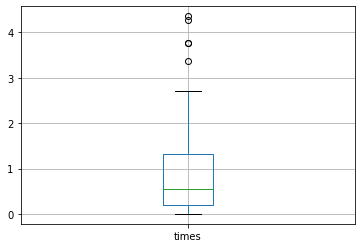

In [ ]:
df = pd.DataFrame({"times": times})
df.boxplot()

In [ ]:
unique_vals = sorted(np.unique(ras_test.prob_grid))
replace_dict = {unique_vals[i]: i for i in range(len(unique_vals))}

new_prob_grid = np.zeros(ras_test.prob_grid.shape)

for i in range(ras_test.prob_grid.shape[0]):
  for j in range(ras_test.prob_grid.shape[1]):
    new_prob_grid[i][j] = replace_dict[ras_test.prob_grid[i][j]]

pretty_print(new_prob_grid.astype(int))

   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   1   3   5   5   5   5   5   5   5   5   5   5   5   5   5
   0   3   5   5   5   5   5   5   5   5   5   5   5   5   5
   2   3   5   5   5   5   5   5   5   5   5   5   5   5   5
   2   3   0   5   5   5   5   5   5   5   5   5   5   5   5
   3   3   5   5   5   5   5   5   5   5   5   5   5   5   5
   4   1   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5


In [ ]:
ras_test.iteration

14

In [ ]:
ras_test.path_followed()

[(0, 0),
 (1, 0),
 (1, 1),
 (2, 1),
 (3, 1),
 (3, 0),
 (4, 0),
 (4, 1),
 (5, 1),
 (6, 1),
 (6, 0),
 (5, 0)]

In [ ]:
gridworld = tuple_2d_array_2_np_array(ras_test.grid)[0].astype(str)
gridworld[ras_test.original_goal[0]][[ras_test.original_goal[1]]] = "$"
gridworld[ras_test.last_start[0]][[ras_test.last_start[1]]] = "S"
gridworld[ras_test.last_goal[0]][[ras_test.last_goal[1]]] = "G"

pretty_print(gridworld)

0   0   0   0   0   1   0   0   1   0   0   1   1   0   1   
0   0   $   0   0   0   1   0   0   0   0   0   0   1   1   
1   0   0   0   0   1   1   0   0   0   0   0   0   1   0   
0   0   0   1   0   1   0   1   0   1   1   0   1   0   0   
0   0   1   1   1   0   0   0   0   0   1   0   0   0   0   
0   0   0   0   1   0   0   0   0   0   1   0   0   1   0   
S   0   1   0   0   1   0   0   0   1   0   0   0   0   0   
G   0   0   0   1   0   1   0   0   0   0   0   0   0   0   
0   0   1   0   0   0   0   0   0   0   0   0   0   1   0   
0   0   0   0   0   0   0   0   1   1   0   0   0   0   0   
0   0   0   0   0   1   0   1   0   0   0   0   0   1   1   
0   1   0   0   1   0   0   0   0   0   0   0   0   1   0   
0   1   0   0   1   0   0   1   1   0   0   0   0   0   0   
0   0   1   0   0   0   0   1   1   0   1   1   0   0   1   
0   0   0   1   0   0   0   0   0   0   0   1   0   0   0   


In [ ]:
pretty_print(tuple_2d_array_2_np_array(ras_test.grid)[0].astype(str))

0   0   0   0   0   1   0   0   1   0   0   1   1   0   1   
0   0   0   0   0   0   1   0   0   0   0   0   0   1   1   
1   0   0   0   0   1   1   0   0   0   0   0   0   1   0   
0   0   0   1   0   1   0   1   0   1   1   0   1   0   0   
0   0   1   1   1   0   0   0   0   0   1   0   0   0   0   
0   0   0   0   1   0   0   0   0   0   1   0   0   1   0   
0   0   1   0   0   1   0   0   0   1   0   0   0   0   0   
1   0   0   0   1   0   1   0   0   0   0   0   0   0   0   
0   0   1   0   0   0   0   0   0   0   0   0   0   1   0   
0   0   0   0   0   0   0   0   1   1   0   0   0   0   0   
0   0   0   0   0   1   0   1   0   0   0   0   0   1   1   
0   1   0   0   1   0   0   0   0   0   0   0   0   1   0   
0   1   0   0   1   0   0   1   1   0   0   0   0   0   0   
0   0   1   0   0   0   0   1   1   0   1   1   0   0   1   
0   0   0   1   0   0   0   0   0   0   0   1   0   0   0   


In [ ]:
pretty_print(tuple_2d_array_2_np_array(ras_test.knowledge_snaps[-1])[0])

   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
